# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow
!pip install matplotlib==2.0.2

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
#X = X.reshape((N,H*W*C))
print(X.shape)

Dataset shape: (400, 32, 32, 3)
(400, 32, 32, 3)


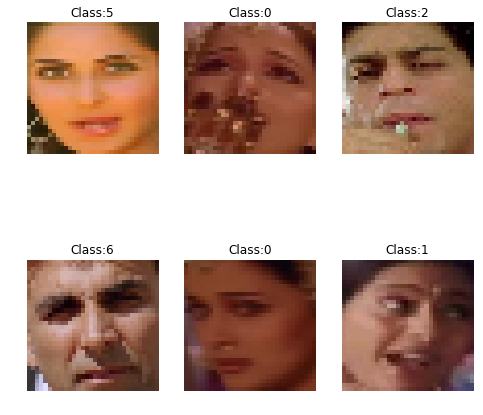

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    #eigenvalues = pca.explained_variance_
    return X_k,pca
# dd=get_pca(X,100)
# print(dd.shape)

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k


### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features
# print(X.shape)
# feat=get_vgg_features("./Assign_dataset/dataset/Yale_face_database")
# print(feat.shape)

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features
# print(X.shape)
# feat=get_resnet_features("./Assign_dataset/dataset/Yale_face_database")
# print(feat.shape)

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)


In [14]:
# Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of 
# human face recognition.
# The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. 
# This produces dimension reduction by allowing the smaller set of basis images to represent the original training 
# images. Classification can be achieved by comparing how faces are represented by the basis set. 

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [15]:
# Compute your features
# eg.
# X_3D = get_kernel_lda(X,y,3)
features=[]
data_sets=[]
data_labels=[]
pcas=[]
eigv=[]
def coV(f):
    Cov=np.cov(np.transpose(f))
#     print(Cov.shape)
    lamda,v=np.linalg.eig(Cov)
    lamda=lamda.real
    return lamda,v

def pc(lamda,lamda_sum):
    req_pc=0
    for req_pc in range(len(lamda)):
        pca_lamda=lamda[0:req_pc]
        pca_lamdasum=np.sum(pca_lamda)
        var_retain=(pca_lamdasum/lamda_sum)*100
        if(var_retain>95):
            return (req_pc+1)

## dataset-1
dirpath = './dataset/IIIT-CFW'
x1,x2 = load_data(dirpath)
N,H,W = x1.shape[0:3]
C = 1 if opt['is_grayscale'] else x1.shape[3]
x1 = x1.reshape((N,H*W*C))
data_sets.append(x1)
data_labels.append(x2)
# print(x1.shape)
x1_3,p1=get_pca(x1,3)

lamda1,v1=coV(x1)
eigv.append(v1)
lamda_sum=np.sum(lamda1)
req_pc=pc(lamda1,lamda_sum)
vec1=[v1[:,i] for i in range(req_pc)]
X_k,pca1=get_pca(x1,req_pc)
features.append(X_k)
pcas.append(pca1)
print(X_k.shape)

## dataset-2
dirpath = './dataset/IMFDB'
y1,y2 = load_data(dirpath)
N,H,W = y1.shape[0:3]
C = 1 if opt['is_grayscale'] else y1.shape[3]
y1 = y1.reshape((N,H*W*C))
y1_3,p2=get_pca(y1,3)
data_sets.append(y1)
data_labels.append(y2)
lamda2,v2=coV(y1)
eigv.append(v2)
lamda_sum=np.sum(lamda2)
req_pc=pc(lamda2,lamda_sum)
vec2=[v2[:,i] for i in range(req_pc)]
Y_k,pca2=get_pca(y1,req_pc)
features.append(Y_k)
pcas.append(pca2)
print(Y_k.shape)

# dataset-3
dirpath = './dataset/Yale_face_database'
z1,z2 = load_data(dirpath)
N,H,W = z1.shape[0:3]
C = 1 if opt['is_grayscale'] else z1.shape[3]
z1 = z1.reshape((N,H*W*C))
z1_3,p3=get_pca(z1,3)
data_sets.append(z1)
data_labels.append(z2)

lamda3,v3=coV(z1)
eigv.append(v3)
lamda_sum=np.sum(lamda3)
req_pc=pc(lamda3,lamda_sum)
vec3=[v3[:,i] for i in range(req_pc)]
Z_k,pca3=get_pca(z1,req_pc)
features.append(Z_k)
pcas.append(pca3)
print(Z_k.shape)

Dataset shape: (672, 32, 32, 3)
(672, 310)
Dataset shape: (400, 32, 32, 3)
(400, 125)
Dataset shape: (165, 32, 32, 3)
(165, 63)


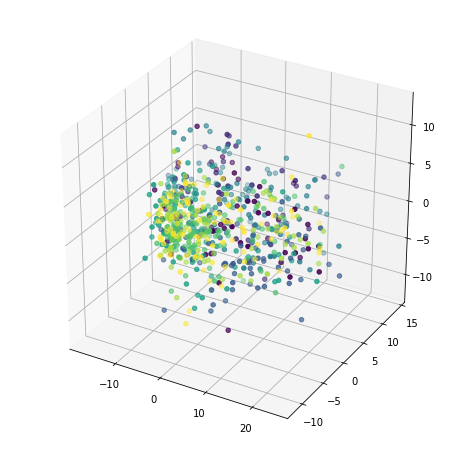

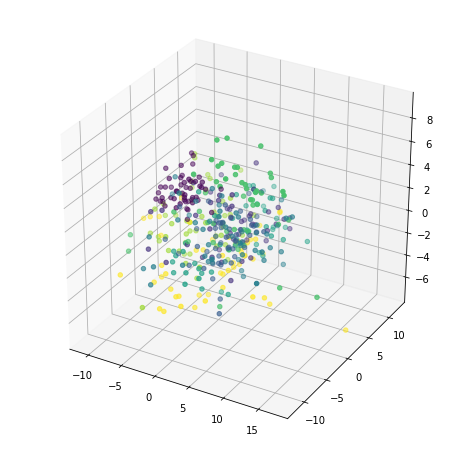

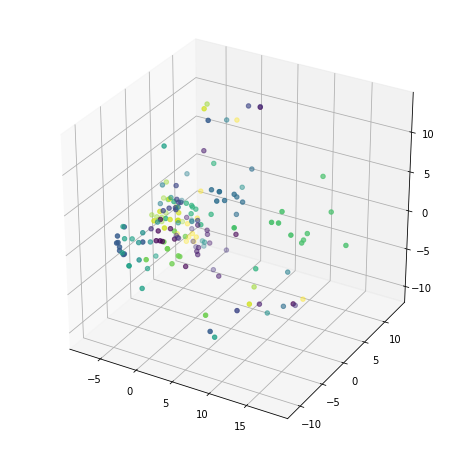

In [16]:
# Create a scatter plot  
# eg.
plt.figure(figsize=(8,8))
ax = plt.axes(projection="3d")
ax.scatter3D(x1_3[:,0],x1_3[:,1],x1_3[:,2],c=x2)
plt.show()
plt.figure(figsize=(8,8))
ax1 = plt.axes(projection="3d")
ax1.scatter3D(y1_3[:,0],y1_3[:,1],y1_3[:,2],c=y2)
plt.show()
plt.figure(figsize=(8,8))
ax2 = plt.axes(projection="3d")
ax2.scatter3D(z1_3[:,0],z1_3[:,1],z1_3[:,2],c=z2)
plt.show()
# ax2 = fig.add_subplot(12, projection='3d')
# ax2.scatter(y1_3[:,0],y1_3[:,1],y1_3[:,2],c=y2)
# ax3 = fig.add_subplot(21, projection='3d')
# ax3.scatter(z1_3[:,0],z1_3[:,1],z1_3[:,2],c=z2)

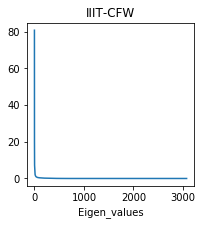

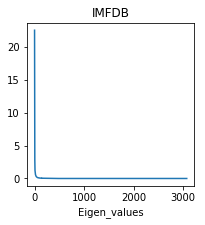

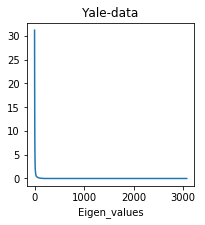

In [17]:
# Plot the eigen value spectrum 
plt.figure(figsize=(3,3))
plt.plot(np.arange(1,len(lamda1)+1),lamda1)
plt.title('IIIT-CFW')
plt.xlabel('Eigen_values')
plt.show()
plt.figure(figsize=(3,3))
plt.plot(np.arange(1,len(lamda2)+1),lamda2)
plt.title('IMFDB')
plt.xlabel('Eigen_values')
plt.show()
plt.figure(figsize=(3,3))
plt.plot(np.arange(1,len(lamda3)+1),lamda3)
plt.title('Yale-data')
plt.xlabel('Eigen_values')
plt.show()

1(c). Reconstruct  the  image  back for each case


In [18]:
def reconstruct_images(data_k,PCA):
    rec_pca=PCA.inverse_transform(data_k)
    return rec_pca    

----------Dataset: IIIT-CFW -------


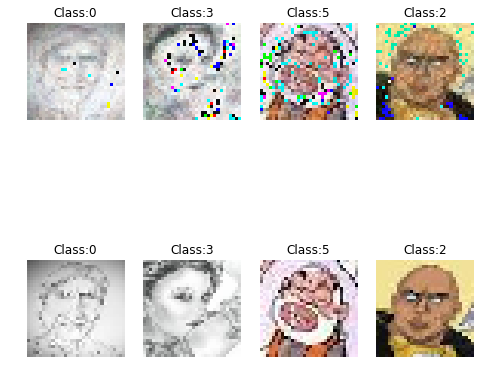

----------Dataset: IMFDB -------


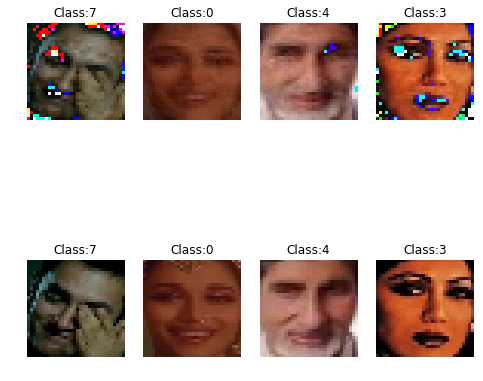

----------Dataset: Yale_data -------


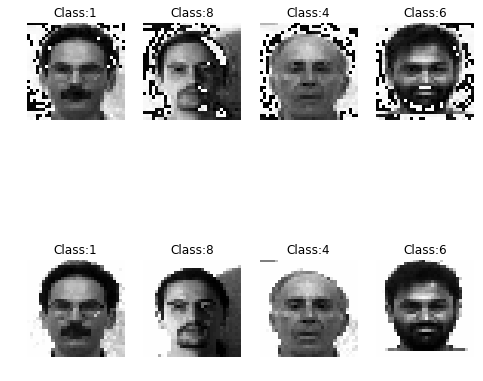

In [19]:
# Display results 
# x1_reconstructed = reconstruct_images(pca1,vec1)
# print(x1_reconstructed.real)
# x1_reconstructed = np.reshape(x1_reconstructed,(672,32,32,3))
# print(x1_reconstructed.shape)
# # Display random images
# # ind = np.random.randint(0,x2.shape[0],6)
# # disply_images(x1_reconstructed[ind,...],x2[ind],row=2,col=3)
# plt.axis('off')
# plt.imshow(x1_reconstructed)
# Show the reconstruction error
# print(x1.shape)
def disp_img(N_size,l,m,name,redu_data,princ):
    rec_pca=reconstruct_images(redu_data,princ)
    rec_pca_test=np.reshape(rec_pca,(N_size,H,W,C))
    ind1=np.random.randint(0,m.shape[0],4)
    X_test = l.reshape([N_size,H,W,C])
    X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
    y_disp = np.concatenate([m[ind1],m[ind1]])
    print("----------Dataset:",name,"-------")
    disply_images(X_disp,y_disp,row=2,col=4)
    
#dataset:IMFDB
data1_disp=disp_img(672,x1,x2,'IIIT-CFW',X_k,pca1)
data1_disp=disp_img(400,y1,y2,'IMFDB',Y_k,pca2)
data1_disp=disp_img(165,z1,z2,'Yale_data',Z_k,pca3)


1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [20]:
Names=['IIIT-CFW','IMFDB','Yale']
for i in range(3):
    print()
    print("Dataset :",Names[i])
    print()
    X_features = features[i]
    y = data_labels[i]
    X = data_sets[i]
    sk_pca = pcas[i]
    vec = eigv[i]

    classes = np.arange(8)
    if Names[i]=='Yale' :
        classes = np.arange(1,16)
    count = np.zeros(len(classes)+1)
    
    Cases = [10,50,100,150,200,]
    X_mean = sk_pca.mean_
    
    for var in Cases:
        vec_1 = vec[:,:var] #dxk
        X_feat1 = np.dot(X - X_mean,vec_1)#dimensional red
        X_reconstructed1 = np.dot(X_feat1,vec_1.T) + X_mean #Nxd
        X_recons_error1 = (X_reconstructed1 - X)**2
    
        cls_recon_error = []
        for j in range(len(classes)):
            disp_cls = X_recons_error1[np.where(y==classes[j])[0]]
            recon_err = np.sqrt(np.mean(disp_cls))
            cls_recon_error.append(recon_err)
        
        cls_recon_error = np.array(cls_recon_error)
        Max_ind1 = cls_recon_error.argsort()[-3:][::-1]
        for j in Max_ind1:
            count[classes[j]]= count[classes[j]]+1

    ######Print most difficult ones
    if Names[i] == 'IIIT-CFW':
        label_dict = cfw_dict
    elif Names[i] == 'Yale':
        label_dict = {}
        for j in range(15):
            label_dict[str(j)] = j+1
#             print(label_dict)        
    elif Names[i] == 'IMFDB':
        label_dict = imfdb_dict
    max_values = count.argsort()[-2:][::-1] #Select the 2 which have more count
#     print(max_values)
    Difficult_ones = [ list(label_dict.keys())[list(label_dict.values()).index(r)] for r in max_values]
    print("Identities that require More Principal components :", Difficult_ones)


Dataset : IIIT-CFW

Identities that require More Principal components : ['ManmohanSingh', 'NarendraModi']

Dataset : IMFDB

Identities that require More Principal components : ['ShilpaShetty', 'AmitabhBachan']

Dataset : Yale

Identities that require More Principal components : ['14', '12']


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [21]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as confuse_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
class Classifier():
    def __init__(self,x1_train,x2_train,x1_test,x2_test):
        #super.__init__()
        self.x1_train=x1_train
        self.x2_train=x2_train
        self.x1_test=x1_test
        self.x2_test=x2_test
    def classify(self,classif):
        """
            Given an input X classify it into appropriate class.
        """
        prediction=classif.predict(self.x1_test)
        return prediction
        
    def confusion_matrix(self,pred):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_mat = confuse_matrix(self.x2_test,pred)
        return confusion_mat
    
    def train(self,param):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label

            @return Nothing
        """
        if param=='MLP':
            classifier=MLPClassifier(hidden_layer_sizes=(100,100),max_iter=200)
            clf=classifier.fit(self.x1_train,self.x2_train)
            print((self.x1_train).shape,(self.x2_train).shape)
            results=self.validate(clf)
            return results
        elif param=='SVM':
            classifier=SVC(C=3,kernel='rbf',random_state=0,gamma=0.1)
            clf=classifier.fit(self.x1_train,self.x2_train)
            results=self.validate(clf)
            return results
        elif param=='Logistic_Regression':
            classifier=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
            clf=classifier.fit(self.x1_train,self.x2_train)
            results=self.validate(clf)
            return results
        elif param=='Decision_trees':
            classifier=tree.DecisionTreeClassifier()
            clf=classifier.fit(self.x1_train,self.x2_train)
            results=self.validate(clf)
            return results
    def validate(self,classifier_para):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        res=[]
        predict=self.classify(classifier_para)
        confusion_mat=self.confusion_matrix(predict)
        accuracy=confusion_mat.trace()/(self.x1_test).shape[0]
        res.append(accuracy*100)
        res.append(confusion_mat)
        metrics=precision_recall_fscore_support(self.x2_test, predict,average='macro')
        req_metrics=[]
        req_metrics.append(metrics[0]*100)
        req_metrics.append(metrics[1]*100)
        req_metrics.append(metrics[2]*100)
        res.extend(req_metrics)
        res=np.array(res[0:5],object)
        return res

In [22]:
# Create a train and validation split to train your classifier
from sklearn.model_selection import train_test_split
from copy import deepcopy
data=["IIIT-CFW","IMFDB","Yale_face_database"]
data_temp=deepcopy(data)
classes=[15,8,8]
for d in range(0,3):
    data[d]="./dataset/"+data[d]
best_classifier=[] 
best_conf_mat=[]
for k in range(0,3):
        s,t = load_data(data[k])
#         print(len(x1))
        N,H,W = s.shape[0:3]
#         print(N,H,W)
        C = 1 if opt['is_grayscale'] else s.shape[3]
        s = s.reshape((N,H*W*C))
        temp_arr=np.arange(s.shape[0])
        train_data=np.array([])
        train_indices=[]
        test_indices=[]
        test_data=np.array([])
        train_labels=[]
        test_labels=[]
        train_data,test_data,train_labels,test_labels=train_test_split(s,t,test_size=0.25)
        mat_metric=[]
        classif=Classifier(train_data,train_labels,test_data,test_labels)
        MLP_classif=classif.train('MLP')
        mat_metric.append(MLP_classif)
        Logis_classif=classif.train('Logistic_Regression')
        mat_metric.append(Logis_classif)
        SVM_classif=classif.train('SVM')
        mat_metric.append(SVM_classif)
        Decision_classif=classif.train('Decision_trees')
        mat_metric.append(Decision_classif)
        mat_metric=np.array(mat_metric)
        best_classifier.append(np.argmax(mat_metric[:,0]))
        best_conf_mat.append(mat_metric[best_classifier[k]][1])
        tmp=np.argmax(mat_metric[:,0])
        print(data_temp[k])
        print("The classification accuracy for the best classifier is %f"%(mat_metric[tmp][0]))
best_classsifier=np.array(best_classifier)
best_conf_mat=np.array(best_conf_mat)

Dataset shape: (672, 32, 32, 3)
(504, 3072) (504,)
IIIT-CFW
The classification accuracy for the best classifier is 48.809524
Dataset shape: (400, 32, 32, 3)
(300, 3072) (300,)
IMFDB
The classification accuracy for the best classifier is 83.000000
Dataset shape: (165, 32, 32, 3)
(123, 3072) (123,)
Yale_face_database
The classification accuracy for the best classifier is 95.238095


In [23]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import pandas as pd
from copy import deepcopy
columns=['Method','Reduced','Classification_error','Accuracy','F1-Score']
index=['1','2','3','4']
tmp_str=["IIIT-CFW","IMFDB","Yale_face_database"]
tmp_str1=deepcopy(tmp_str)
for d in range(0,3):
    tmp_str[d]="./dataset/"+tmp_str[d]
data=[]

func_arr=[get_pca,get_kernel_pca,get_lda,get_kernel_lda,get_vgg_features,get_resnet_features]
func_str=['get_pca','get_kernel_pca','get_lda','get_kernel_lda','get_vgg_features','get_resnet_features']
classif_arr=['MLP','Logistic_Regression','SVM','Decision_trees']
conf_mat=[]
for i in range(0,3):
    g,h = load_data(tmp_str[i])
    N,H,W = g.shape[0:3]
    C = 1 if opt['is_grayscale'] else g.shape[3]
    g = g.reshape((N,H*W*C))
    for j in range(0,len(func_arr)):
        if j==0:
            feat,f_shit=func_arr[j](g,100)
        if j==2:
            feat=func_arr[j](g,h,100)
        if j==4 or j==5:
            feat=func_arr[j](tmp_str[i])
        if j==1:
            feat=func_arr[j](g,100,kernel='rbf', degree=3)
        if j==3:
            feat=func_arr[j](g,h,100,kernel='rbf',degree=3)
        for k in range(0,len(classif_arr)):
            train_data,test_data,train_labels,test_labels=train_test_split(feat,h,test_size=0.25)
            classif=Classifier(train_data,train_labels,test_data,test_labels)
            temp_classif=classif.train(classif_arr[k])
            conf_mat.append(temp_classif[1])
            s3 = "{}+{}".format(func_str[j],classif_arr[k])
            data.append([s3,feat.shape[1],100-temp_classif[0],temp_classif[0],temp_classif[4]])
            
data=np.array(data)
print(data.shape)
dd=0
while dd<data.shape[0]:
    df=pd.DataFrame(data[dd:dd+4],columns=columns, index=index)
    if dd>=0 and dd<24:
        print("IIIT-CFW")
    elif dd>=24 and dd<48:
        print("IMFDB")
    else:
        print("Yale-face-database")
    display(df)
    dd=dd+4

Dataset shape: (672, 32, 32, 3)
(504, 100) (504,)
(504, 100) (504,)
(504, 7) (504,)
(504, 7) (504,)
(504, 4096) (504,)
(504, 2048) (504,)
Dataset shape: (400, 32, 32, 3)
(300, 100) (300,)
(300, 100) (300,)
(300, 7) (300,)
(300, 7) (300,)
(300, 4096) (300,)
(300, 2048) (300,)
Dataset shape: (165, 32, 32, 3)
(123, 100) (123,)
(123, 100) (123,)
(123, 14) (123,)
(123, 14) (123,)
(123, 4096) (123,)
(123, 2048) (123,)
(72, 5)
IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,47.0238095238,52.9761904762,52.6643495102
2,get_pca+Logistic_Regression,100,52.380952381,47.619047619,49.4755693556
3,get_pca+SVM,100,86.9047619048,13.0952380952,4.52561936937
4,get_pca+Decision_trees,100,72.619047619,27.380952381,28.0910062357


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,50.5952380952,49.4047619048,46.0336350331
2,get_kernel_pca+Logistic_Regression,100,63.6904761905,36.3095238095,30.5690557203
3,get_kernel_pca+SVM,100,67.8571428571,32.1428571429,22.9060105677
4,get_kernel_pca+Decision_trees,100,76.7857142857,23.2142857143,22.1027255992


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,7,4.7619047619,95.2380952381,95.174564871
2,get_lda+Logistic_Regression,7,2.38095238095,97.619047619,97.7139570934
3,get_lda+SVM,7,3.57142857143,96.4285714286,95.535110394
4,get_lda+Decision_trees,7,1.78571428571,98.2142857143,97.878769722


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,7,4.7619047619,95.2380952381,94.10562133
2,get_kernel_lda+Logistic_Regression,7,1.19047619048,98.8095238095,99.0130110015
3,get_kernel_lda+SVM,7,0.595238095238,99.4047619048,99.3902439024
4,get_kernel_lda+Decision_trees,7,7.7380952381,92.2619047619,89.6135052655


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,34.5238095238,65.4761904762,61.310086089
2,get_vgg_features+Logistic_Regression,4096,33.3333333333,66.6666666667,62.332577362
3,get_vgg_features+SVM,4096,35.7142857143,64.2857142857,60.116875586
4,get_vgg_features+Decision_trees,4096,35.7142857143,64.2857142857,60.2257218354


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,4.16666666667,95.8333333333,95.6761977271
2,get_resnet_features+Logistic_Regression,2048,2.38095238095,97.619047619,97.0345624402
3,get_resnet_features+SVM,2048,48.8095238095,51.1904761905,45.3742600502
4,get_resnet_features+Decision_trees,2048,5.35714285714,94.6428571429,95.3875392826


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,16.0,84.0,84.7774232473
2,get_pca+Logistic_Regression,100,25.0,75.0,74.5644009774
3,get_pca+SVM,100,65.0,35.0,41.3899208806
4,get_pca+Decision_trees,100,52.0,48.0,47.2215563772


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,19.0,81.0,80.4494059788
2,get_kernel_pca+Logistic_Regression,100,54.0,46.0,42.2034705491
3,get_kernel_pca+SVM,100,80.0,20.0,13.0479582146
4,get_kernel_pca+Decision_trees,100,56.0,44.0,44.2951373339


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,7,1.0,99.0,98.7468671679
2,get_lda+Logistic_Regression,7,1.0,99.0,98.9047619048
3,get_lda+SVM,7,3.0,97.0,97.0755524432
4,get_lda+Decision_trees,7,3.0,97.0,96.0013227513


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,7,4.0,96.0,96.3990504748
2,get_kernel_lda+Logistic_Regression,7,2.0,98.0,97.9949832776
3,get_kernel_lda+SVM,7,3.0,97.0,97.0331041508
4,get_kernel_lda+Decision_trees,7,6.0,94.0,93.300845043


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,13.0,87.0,86.8010069641
2,get_vgg_features+Logistic_Regression,4096,8.0,92.0,91.7791005291
3,get_vgg_features+SVM,4096,37.0,63.0,64.7332262142
4,get_vgg_features+Decision_trees,4096,16.0,84.0,82.8420745921


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,10.0,90.0,89.5228142555
2,get_resnet_features+Logistic_Regression,2048,8.0,92.0,92.0154273831
3,get_resnet_features+SVM,2048,51.0,49.0,56.5518825981
4,get_resnet_features+Decision_trees,2048,9.0,91.0,91.1353986387


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,9.52380952381,90.4761904762,91.1957671958
2,get_pca+Logistic_Regression,100,9.52380952381,90.4761904762,90.9682539683
3,get_pca+SVM,100,76.1904761905,23.8095238095,36.6666666667
4,get_pca+Decision_trees,100,23.8095238095,76.1904761905,71.8095238095


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,9.52380952381,90.4761904762,91.6825396825
2,get_kernel_pca+Logistic_Regression,100,61.9047619048,38.0952380952,36.1587301587
3,get_kernel_pca+SVM,100,92.8571428571,7.14285714286,3.4126984127
4,get_kernel_pca+Decision_trees,100,54.7619047619,45.2380952381,41.7301587302


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,14,0.0,100.0,100.0
2,get_lda+Logistic_Regression,14,0.0,100.0,100.0
3,get_lda+SVM,14,9.52380952381,90.4761904762,91.8070818071
4,get_lda+Decision_trees,14,11.9047619048,88.0952380952,89.555962556


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,14,0.0,100.0,100.0
2,get_kernel_lda+Logistic_Regression,14,0.0,100.0,100.0
3,get_kernel_lda+SVM,14,16.6666666667,83.3333333333,85.2698412698
4,get_kernel_lda+Decision_trees,14,11.9047619048,88.0952380952,81.684981685


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,47.619047619,52.380952381,45.5132275132
2,get_vgg_features+Logistic_Regression,4096,38.0952380952,61.9047619048,60.1587301587
3,get_vgg_features+SVM,4096,92.8571428571,7.14285714286,8.12865497076
4,get_vgg_features+Decision_trees,4096,57.1428571429,42.8571428571,43.0844155844


Yale-face-database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,2.38095238095,97.619047619,97.1428571429
2,get_resnet_features+Logistic_Regression,2048,2.38095238095,97.619047619,97.1428571429
3,get_resnet_features+SVM,2048,80.9523809524,19.0476190476,26.1904761905
4,get_resnet_features+Decision_trees,2048,28.5714285714,71.4285714286,70.185528757


In [24]:
# For each dataset print the confusion matrix for the best model
data1=data[0:24]
data2=data[24:48]
data3=data[48:72]
data1=np.array(data1)
temp_col=data1[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[0:24]
conf=conf_data1[ind_max]
print("The best model is:-")
print("---------------------")
print(data1[ind_max][0])
print("\n")
print(conf)

data2=np.array(data2)
temp_col=data2[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[24:48]
conf=conf_data1[ind_max]
print("The best model is:-")
print("----------------------")
print(data2[ind_max][0])
print("\n")
print(conf)

data3=np.array(data3)
temp_col=data3[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[48:72]
conf=conf_data1[ind_max]
print("The best model is:-")
print("----------------------")
print(data3[ind_max][0])
print("\n")
print(conf)

The best model is:-
---------------------
get_kernel_lda+SVM


[[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0 20  1  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0 24]]
The best model is:-
----------------------
get_lda+MLP


[[13  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  1]
 [ 0  0  0 11  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  9]]
The best model is:-
----------------------
get_lda+MLP


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

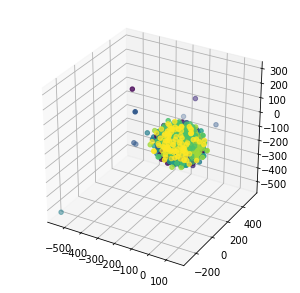

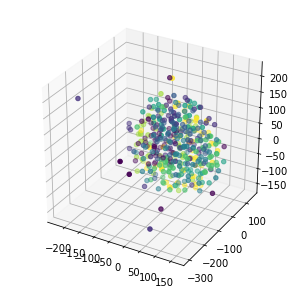

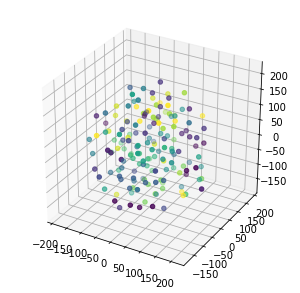

In [25]:
# Compute TSNE for different features and create a scatter plot
def tsne(u,v):
    k = 3 # Number of components in TSNE
    # Compute
    X_TSNE = TSNE(n_components=k).fit_transform(u)
    # print(X_TSNE.shape)
    plt.figure(figsize=(5,5))
    ax = plt.axes(projection="3d")
    ax.scatter3D(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=v)
    plt.show()
# Plot the representation in 2d/3d
tsne(x1,x2)
tsne(y1,y2)
tsne(z1,z2)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [26]:
from sklearn.metrics import confusion_matrix as confuse_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
class FaceVerification():
    def __init__(self,x1_train,x2_train,x1_test,x2_test):
        #super.__init__()
        self.x1_train=x1_train
        self.x2_train=x2_train
        self.x1_test=x1_test
        self.x2_test=x2_test
    def verify(self,classif):
        """
            Given an input X classify it into appropriate class.
        """
        prediction=classif.predict(self.x1_test)
        return prediction
        
    def confusion_matrix(self,pred):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_mat= confuse_matrix(self.x2_test,pred)
        return confusion_mat
    
    def train(self,params):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label

            @return Nothing
        """
        if params=='KNN':
            classifier=KNeighborsClassifier(n_neighbors=6)
            clf=classifier.fit(self.x1_train,self.x2_train)
            final=self.validate(clf)
            return final
    def validate(self,clf_param):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        result=[]
        predict=self.verify(clf_param)
        confusion_mat=self.confusion_matrix(predict)
        accuracy=confusion_mat.trace()/(self.x1_test).shape[0]
        result.append(accuracy*100)
        result.append(confusion_mat)
        metrics=precision_recall_fscore_support(self.x2_test, predict,average='macro')
        req_metrics=[]
        req_metrics.append(metrics[0]*100)
        req_metrics.append(metrics[1]*100)
        req_metrics.append(metrics[2]*100)
        result.extend(req_metrics)
        result=np.array(result[0:5],object)
        return result

In [27]:
# Create a train and validation split and show your results
req_data=["IIIT-CFW","IMFDB","Yale_face_database"]
classes=[15,8,8]
for d in range(0,3):
    req_data[d]="./dataset/"+req_data[d]
best_classifier=[] 
best_conf_mat=[]
for k in range(0,3):
        e,f = load_data(req_data[k])
#         print(len(x1))
        N,H,W = e.shape[0:3]
#         print(N,H,W)
        C = 1 if opt['is_grayscale'] else e.shape[3]
        e = e.reshape((N,H*W*C))
        temp_arr=np.arange(e.shape[0])
        train_data=np.array([])
        train_indices=[]
        test_indices=[]
        test_data=np.array([])
        train_labels=[]
        test_labels=[]
        train_data,test_data,train_labels,test_labels=train_test_split(e,f)
        mat_metric=[]
        
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        #classif=FaceVerification(X,y,X,y)
        KNN_classif=classif.train('KNN')
        mat_metric.append(KNN_classif)
        mat_metric=np.array(mat_metric)
#         print(data[k])
        print("The classification accuracy is:-")
        print(mat_metric[0][0])

Dataset shape: (672, 32, 32, 3)
The classification accuracy is:-
28.5714285714
Dataset shape: (400, 32, 32, 3)
The classification accuracy is:-
56.0
Dataset shape: (165, 32, 32, 3)
The classification accuracy is:-
66.6666666667


In [28]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
data=[]
KNN_index=['1','2','3','4','5','6']
for i in range(0,3):
        q,w = load_data(req_data[i])
        N,H,W = q.shape[0:3]
        C = 1 if opt['is_grayscale'] else q.shape[3]
        q = q.reshape((N,H*W*C))
        
        resnet_dim_red=get_resnet_features(req_data[i])
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['Resnet+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
        resnet_dim_red=get_vgg_features(req_data[i])
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['vgg+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
        resnet_dim_red,spca1=get_pca(q,100)
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['Pca+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
        resnet_dim_red=get_kernel_pca(q,100,kernel='rbf', degree=3)
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['Kenrel_PCA+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
        resnet_dim_red=get_lda(q,w,100)
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['LDA+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
        resnet_dim_red=get_kernel_lda(q,w,100,kernel='rbf',degree=3)
        train_data,test_data,train_labels,test_labels=train_test_split(resnet_dim_red,w,test_size=0.25)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        KNN_classif=classif.train('KNN')
        data.append(['Kernel_LDA+KNN',resnet_dim_red.shape[1],100-KNN_classif[0],KNN_classif[0],KNN_classif[4]])
        
df1 = pd.DataFrame(data[0:6],columns=columns, index=KNN_index)
df2 = pd.DataFrame(data[6:12],columns=columns, index=KNN_index)
df3 = pd.DataFrame(data[12:18],columns=columns, index=KNN_index)

print("IIIT-CFW")
display(df1)
print("IMFDB")
display(df2)
print("Yale_face_database")
display(df3)


Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,Resnet+KNN,2048,1.785714,98.214286,97.763520
2,vgg+KNN,4096,28.571429,71.428571,68.710167
3,Pca+KNN,100,65.476190,34.523810,35.686277
4,Kenrel_PCA+KNN,100,62.500000,37.500000,37.923742
5,LDA+KNN,7,2.976190,97.023810,96.582208
6,Kernel_LDA+KNN,7,2.976190,97.023810,96.786634


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,Resnet+KNN,2048,5.0,95.0,93.800595
2,vgg+KNN,4096,9.0,91.0,90.400538
3,Pca+KNN,100,45.0,55.0,52.423852
4,Kenrel_PCA+KNN,100,42.0,58.0,56.639405
5,LDA+KNN,7,2.0,98.0,98.028274
6,Kernel_LDA+KNN,7,2.0,98.0,98.168344


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,Resnet+KNN,2048,0.000000,100.000000,100.000000
2,vgg+KNN,4096,40.476190,59.523810,59.798942
3,Pca+KNN,100,28.571429,71.428571,73.769120
4,Kenrel_PCA+KNN,100,28.571429,71.428571,71.916100
5,LDA+KNN,14,0.000000,100.000000,100.000000
6,Kernel_LDA+KNN,14,0.000000,100.000000,100.000000


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [29]:
# Load data
from sklearn.model_selection import train_test_split
cfw_dict_modified = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 0,
    'BarackObama': 1,
    'NarendraModi': 1,
    'ManmohanSingh': 1,
    'VladimirPutin': 1}

def load_data_modified(dir_path):
    image_list = []
    y_list = []
    if "CFW" in dir_path:
        label_dict =cfw_dict_modified
    else:
        raise KeyError("Dataset not found.")
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            tag = label_dict[y] 
            if(tag==0):
                image_list.append(im)
                y_list.append(0)
                #print(y)
            elif(tag==1):
                image_list.append(im)
                y_list.append(1)
                #print(y)
            else:
                print('INVALID')
                
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",y_list.shape)
    return image_list,y_list
p,q=load_data_modified("./dataset/IIIT-CFW")
N,H,W = p.shape[0:3]
C = 1 if opt['is_grayscale'] else p.shape[3]
p = p.reshape((N,H*W*C))
print(p.shape)
print(q.shape)

Dataset shape: (672,)
(672, 3072)
(672,)


In [30]:
# Define your features
x_rdd=get_resnet_features("./dataset/IIIT-CFW")
X_train,X_test,y_train,y_test=train_test_split(x_rdd,q,test_size=0.25)
print(X_test.shape)

(168, 2048)


In [31]:
# Create your classifier
classy=MLPClassifier(hidden_layer_sizes=(1024,512,64),max_iter=200,batch_size=20,activation='relu')
clf=classy.fit(X_train,y_train)
final=clf.predict(X_test)
confusion_mat1=confuse_matrix(y_test,final)
# Validate your classifier
req_list=np.abs(final-y_test)
# req_index=req_list.index(1)
print(req_list)
req_ar=np.where(req_list==1)[0]
print(req_ar)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2 21 67]


The accuracy is:
98.2142857143
The k-fold validation accuracy is:
0.946478717523
TSNE Plot for IIIT-CFW


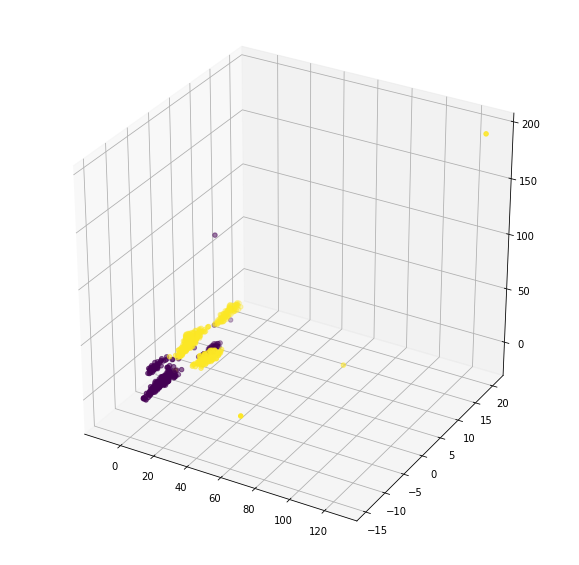

In [32]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
from sklearn.model_selection import cross_val_score
print("The accuracy is:")
print((confusion_mat1.trace()/y_test.shape[0])*100)
scores = cross_val_score(clf, x_rdd, q, cv=5, scoring='accuracy')
print("The k-fold validation accuracy is:")
print(np.mean(scores))
X_TSNE = TSNE(n_components=3).fit_transform(x_rdd)
X1_3D=X_TSNE
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=q)
print("TSNE Plot for IIIT-CFW")
plt.show()

In [33]:
# Show quantitative results such as examples of correct prediction and wrong prediction
